In [1]:
import scanpy as sc
import scvi
import scib

from ray import tune
from ray.tune.schedulers import ASHAScheduler

Global seed set to 0


## Read data

In [4]:
pbmca = sc.read_10x_mtx("../data/10X/frozen_pbmc_donor_a/filtered_matrices_mex/hg19")
pbmcb = sc.read_10x_mtx("../data/10X/frozen_pbmc_donor_b/filtered_matrices_mex/hg19")


In [5]:
print(f"Number of cells in A: {pbmca.shape[0]}")
print(f"Number of cells in B: {pbmcb.shape[0]}")

Number of cells in A: 2900
Number of cells in B: 7783


In [6]:
adata = pbmca.concatenate(pbmcb)
del(pbmca, pbmcb)

/home/mdmanurung/mambaforge/envs/integratune/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## QC

In [7]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith("MT-")

# ribosomal
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,mt,ribo,hb
MIR1302-10,ENSG00000243485,False,False,False
FAM138A,ENSG00000237613,False,False,False
OR4F5,ENSG00000186092,False,False,False
RP11-34P13.7,ENSG00000238009,False,False,False
RP11-34P13.8,ENSG00000239945,False,False,False
...,...,...,...,...
AC145205.1,ENSG00000215635,False,False,False
BAGE5,ENSG00000268590,False,False,False
CU459201.1,ENSG00000251180,False,False,False
AC002321.2,ENSG00000215616,False,False,False


In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

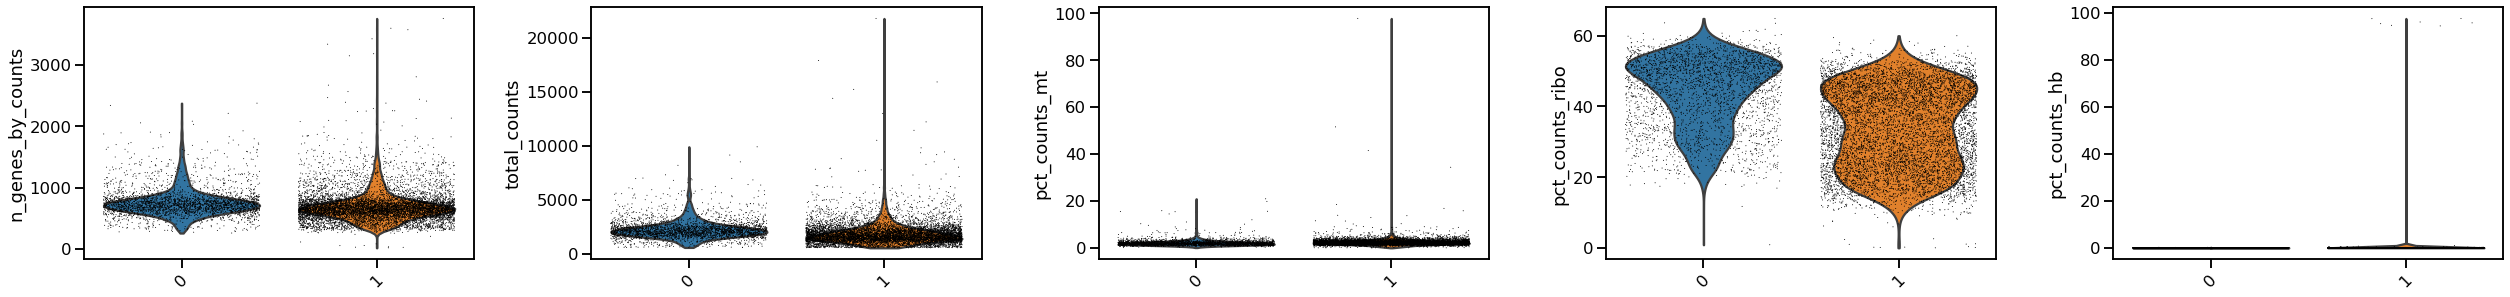

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'batch', rotation= 45)

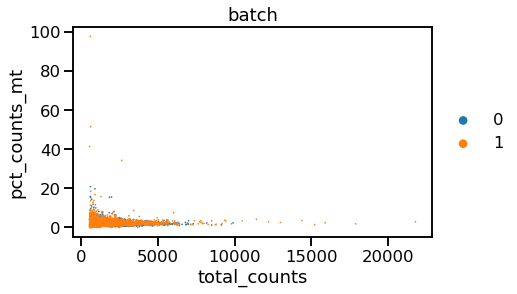

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="batch")

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

10675 15225


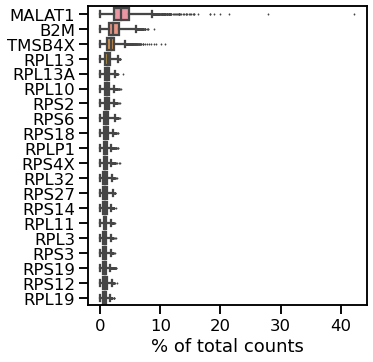

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

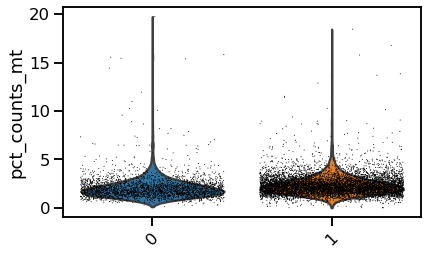

In [13]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, groupby = 'batch', rotation= 45)

In [14]:
adata.write_h5ad("../data/adata.h5ad")

In [15]:
adata = sc.read_h5ad("../data/adata.h5ad")
adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 10671 × 15225
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors'
    layers: 'counts'

## SCVI

In [16]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)

In [17]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["batch"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"]
)

In [71]:
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [72]:
model.train()

/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/mdmanurung/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [27:17<00:00,  4.09s/it, loss=312, v_num=1]


In [74]:
alatent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

AnnData object with n_obs × n_vars = 10671 × 2000
    obs: 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI'
    layers: 'counts'

In [2]:
#adata.write("../data/adata_scvi.h5ad")
adata = sc.read_h5ad("../data/adata_scvi.h5ad")

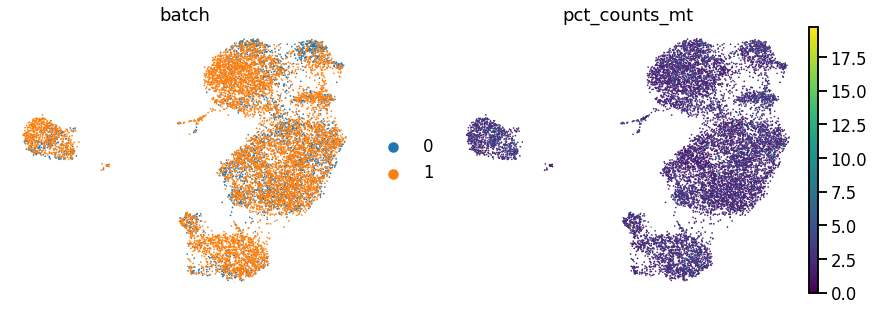

In [3]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["batch", "pct_counts_mt"],
    frameon=False,
)

In [4]:
import scib

In [26]:
import random
import pandas as pd
import numpy as np
string = "ABCD"
adata.obs['label'] = [random.choice(string) for i in np.arange(adata.shape[0])]
adata.obs.label.value_counts()

In [36]:
adata.obs.label = adata.obs.label.astype("category")

In [37]:
scib.metrics.graph_connectivity(adata, label_key="label")

0.9923694017211785

In [42]:
scib.metrics.silhouette_batch(adata, batch_key="batch", group_key="label", embed="X_scVI", metric='euclidean', return_all=False, scale=True, verbose=True)

/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/scib/metrics/silhouette.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(
/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/scib/metrics/silhouette.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(
/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/scib/metrics/silhouette.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(


mean silhouette per group:        silhouette_score
group                  
A              0.975819
B              0.969500
C              0.974671
D              0.977247


/home/mdmanurung/.cache/pypoetry/virtualenvs/integratune-ySsuEvPr-py3.9/lib/python3.9/site-packages/scib/metrics/silhouette.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(


0.9743092991259953